In [1]:
import os
import sys
import time
import json
import matplotlib.pyplot as plt
sys.path.append("/home/ziniuw/zero-shot-cost-estimation")
from models.zero_shot_models.specific_models.model import zero_shot_models
from cross_db_benchmark.benchmark_tools.database import DatabaseSystem
from models.training.train import train_default, train_readout_hyperparams

Using backend: pytorch


In [2]:
from copy import copy

import numpy as np
import optuna
import torch
import torch.optim as opt
from tqdm import tqdm

from cross_db_benchmark.benchmark_tools.utils import load_json
from models.dataset.dataset_creation import create_dataloader
from models.training.checkpoint import save_checkpoint, load_checkpoint, save_csv
from models.training.metrics import MAPE, RMSE, QError
from models.training.utils import batch_to, flatten_dict, find_early_stopping_metric
from models.zero_shot_models.specific_models.model import zero_shot_models

def training_model_loader(workload_runs,
                test_workload_runs,
                statistics_file,
                target_dir,
                filename_model,
                optimizer_class_name='Adam',
                optimizer_kwargs=None,
                final_mlp_kwargs=None,
                node_type_kwargs=None,
                model_kwargs=None,
                tree_layer_name='GATConv',
                tree_layer_kwargs=None,
                hidden_dim=32,
                batch_size=32,
                output_dim=1,
                epochs=0,
                device='cpu',
                plan_featurization_name=None,
                max_epoch_tuples=100000,
                param_dict=None,
                num_workers=1,
                early_stopping_patience=20,
                trial=None,
                database=None,
                limit_queries=None,
                limit_queries_affected_wl=None,
                skip_train=False,
                seed=0):
    if model_kwargs is None:
        model_kwargs = dict()

    # seed for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)

    target_test_csv_paths = []
    if test_workload_runs is not None:
        for p in test_workload_runs:
            test_workload = os.path.basename(p).replace('.json', '')
            target_test_csv_paths.append(os.path.join(target_dir, f'test_{filename_model}_{test_workload}.csv'))

    # create a dataset
    loss_class_name = final_mlp_kwargs['loss_class_name']
    label_norm, feature_statistics, train_loader, val_loader, test_loaders = \
        create_dataloader(workload_runs, test_workload_runs, statistics_file, plan_featurization_name, database,
                          val_ratio=0.15, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                          pin_memory=False, limit_queries=limit_queries,
                          limit_queries_affected_wl=limit_queries_affected_wl, loss_class_name=loss_class_name)

    if loss_class_name == 'QLoss':
        metrics = [RMSE(), MAPE(), QError(percentile=50, early_stopping_metric=True), QError(percentile=95),
                   QError(percentile=100)]
    elif loss_class_name == 'MSELoss':
        metrics = [RMSE(early_stopping_metric=True), MAPE(), QError(percentile=50), QError(percentile=95),
                   QError(percentile=100)]

    # create zero shot model dependent on database
    model = zero_shot_models[database](device=device, hidden_dim=hidden_dim, final_mlp_kwargs=final_mlp_kwargs,
                                       node_type_kwargs=node_type_kwargs, output_dim=output_dim,
                                       feature_statistics=feature_statistics, tree_layer_name=tree_layer_name,
                                       tree_layer_kwargs=tree_layer_kwargs,
                                       plan_featurization_name=plan_featurization_name,
                                       label_norm=label_norm,
                                       **model_kwargs)
    # move to gpu
    model = model.to(model.device)
    optimizer = opt.__dict__[optimizer_class_name](model.parameters(), **optimizer_kwargs)
    csv_stats, epochs_wo_improvement, epoch, model, optimizer, metrics, finished = \
        load_checkpoint(model, target_dir, filename_model, optimizer=optimizer, metrics=metrics, filetype='.pt')
    return test_loaders, model

def load_model(workload_runs,
            test_workload_runs,
               statistics_file,
               target_dir,
               filename_model,
               hyperparameter_path,
              device='cpu',
              max_epoch_tuples=100000,
              num_workers=1,
              loss_class_name='QLoss',
              database=None,
              seed=0,
              limit_queries=None,
              limit_queries_affected_wl=None,
              max_no_epochs=None,
              skip_train=False
              ):
    """
    Reads out hyperparameters and trains model
    """
    print(f"Reading hyperparameters from {hyperparameter_path}")
    hyperparams = load_json(hyperparameter_path, namespace=False)

    p_dropout = hyperparams.pop('p_dropout')
    # general fc out
    fc_out_kwargs = dict(p_dropout=p_dropout,
                         activation_class_name='LeakyReLU',
                         activation_class_kwargs={},
                         norm_class_name='Identity',
                         norm_class_kwargs={},
                         residual=hyperparams.pop('residual'),
                         dropout=hyperparams.pop('dropout'),
                         activation=True,
                         inplace=True)
    final_mlp_kwargs = dict(width_factor=hyperparams.pop('final_width_factor'),
                            n_layers=hyperparams.pop('final_layers'),
                            loss_class_name=loss_class_name,
                            loss_class_kwargs=dict())
    tree_layer_kwargs = dict(width_factor=hyperparams.pop('tree_layer_width_factor'),
                             n_layers=hyperparams.pop('message_passing_layers'))
    node_type_kwargs = dict(width_factor=hyperparams.pop('node_type_width_factor'),
                            n_layers=hyperparams.pop('node_layers'),
                            one_hot_embeddings=True,
                            max_emb_dim=hyperparams.pop('max_emb_dim'),
                            drop_whole_embeddings=False)
    final_mlp_kwargs.update(**fc_out_kwargs)
    tree_layer_kwargs.update(**fc_out_kwargs)
    node_type_kwargs.update(**fc_out_kwargs)

    train_kwargs = dict(optimizer_class_name='AdamW',
                        optimizer_kwargs=dict(
                            lr=hyperparams.pop('lr'),
                        ),
                        final_mlp_kwargs=final_mlp_kwargs,
                        node_type_kwargs=node_type_kwargs,
                        tree_layer_kwargs=tree_layer_kwargs,
                        tree_layer_name=hyperparams.pop('tree_layer_name'),
                        plan_featurization_name=hyperparams.pop('plan_featurization_name'),
                        hidden_dim=hyperparams.pop('hidden_dim'),
                        output_dim=1,
                        epochs=200 if max_no_epochs is None else max_no_epochs,
                        early_stopping_patience=20,
                        max_epoch_tuples=max_epoch_tuples,
                        batch_size=hyperparams.pop('batch_size'),
                        device=device,
                        num_workers=num_workers,
                        seed=seed,
                        limit_queries=limit_queries,
                        limit_queries_affected_wl=limit_queries_affected_wl,
                        skip_train=skip_train
                        )

    assert len(hyperparams) == 0, f"Not all hyperparams were used (not used: {hyperparams.keys()}). Hence generation " \
                                  f"and reading does not seem to fit"

    param_dict = flatten_dict(train_kwargs)
    
    test_loaders, model = training_model_loader(workload_runs, test_workload_runs, statistics_file, target_dir, filename_model, 
                          param_dict=param_dict, database=database, **train_kwargs)
    
    return test_loaders, model

def validate_model(val_loader, model, epoch=0, epoch_stats=None, metrics=None, max_epoch_tuples=None,
                   custom_batch_to=batch_to, verbose=False, log_all_queries=False):
    model.eval()
    print(model.plan_featurization_name)
    with torch.autograd.no_grad():
        val_loss = torch.Tensor([0])
        labels = []
        preds = []
        probs = []
        sample_idxs = []

        # evaluate test set using model
        test_start_t = time.perf_counter()
        val_num_tuples = 0
        for batch_idx, batch in enumerate(tqdm(val_loader)):
            if max_epoch_tuples is not None and batch_idx * val_loader.batch_size > max_epoch_tuples:
                break
            val_num_tuples += val_loader.batch_size

            input_model, label, sample_idxs_batch = custom_batch_to(batch, model.device, model.label_norm)
            #sample_idxs += sample_idxs_batch
            output = model(input_model)

            # sum up mean batch losses
            val_loss += model.loss_fxn(output, label).cpu()

            # inverse transform the predictions and labels
            curr_pred = output.cpu().numpy()
            curr_label = label.cpu().numpy()
            if model.label_norm is not None:
                curr_pred = model.label_norm.inverse_transform(curr_pred)
                curr_label = model.label_norm.inverse_transform(curr_label.reshape(-1, 1))
                curr_label = curr_label.reshape(-1)
           
            preds.append(curr_pred.reshape(-1))
            labels.append(curr_label.reshape(-1))

        if epoch_stats is not None:
            epoch_stats.update(val_time=time.perf_counter() - test_start_t)
            epoch_stats.update(val_num_tuples=val_num_tuples)
            val_loss = (val_loss.cpu() / len(val_loader)).item()
            print(f'val_loss epoch {epoch}: {val_loss}')
            epoch_stats.update(val_loss=val_loss)

        labels = np.concatenate(labels, axis=0)
        preds = np.concatenate(preds, axis=0)
        return labels, preds

In [3]:
def test_one_model(target_dir, filename_model, hyperparameter_path, test_workload_runs=
                   ["/home/ziniuw/zero-shot-data/runs/parsed_plans/imdb_full/complex_queries_testing_2k.json"],
                   statistics_file="/home/ziniuw/zero-shot-data/runs/parsed_plans/statistics_workload_combined.json"):
    database = DatabaseSystem.POSTGRES
    test_loaders, model = load_model(test_workload_runs, test_workload_runs, statistics_file, target_dir, filename_model,
                  hyperparameter_path, database=database)
    true, pred = validate_model(test_loaders[0], model)
    qerror = np.maximum(true/pred, pred/true)
    res = []
    for i in [50, 95, 99]:
        print(f"{i} percentile is {np.percentile(qerror, i)}")
        res.append(np.percentile(qerror, i))
    return res, true, pred

        

In [15]:
training_script = "python3 train.py --train_model --workload_runs ../zero-shot-data/runs/parsed_plans/imdb_full/complex_queries_training_50k.json --target ../zero-shot-data/evaluation/job_full_few_shot_tune/ --hyperparameter_path setup/tuned_hyperparameters/tune_{}best_config.json --seed 0 --limit_queries {} --limit_queries_affected_wl 1 --filename_model imdb_full_{}lmtq_{} --save_best"
print(training_script)

python3 train.py --train_model --workload_runs ../zero-shot-data/runs/parsed_plans/imdb_full/complex_queries_training_50k.json --target ../zero-shot-data/evaluation/job_full_few_shot_tune/ --hyperparameter_path setup/tuned_hyperparameters/tune_{}best_config.json --seed 0 --limit_queries {} --limit_queries_affected_wl 1 --filename_model imdb_full_{}lmtq_{} --save_best


In [8]:
num_query_list = [1000, 5000, 10000, 50000]
train_with_list = ["", "est_"]
target_dir = "/home/ziniuw/zero-shot-data/evaluation/job_full_few_shot_tune/"
test_workload_runs = ["/home/ziniuw/zero-shot-data/runs/MSCN_augmented/imdb_full/complex_queries_testing_2k.json"]
hyperparameter_paths = {
    "True Card": "/home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_best_config.json",
    "PG_est Card": "/home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_est_best_config.json"
}


for num_query in num_query_list:
    for train_with in train_with_list:
        curr_train_script = training_script.format(train_with, num_query, train_with, num_query)
        filename_model = f"imdb_full_{train_with}lmtq_{num_query}"
        if os.path.exists(target_dir + filename_model + ".pt"):
            for test_with in hyperparameter_paths:
                hyperparameter_path = hyperparameter_paths[test_with]
                print("***************************************************************")
                if train_with == "":
                    train_with_str = "True Card"
                else:
                    train_with_str = "PG est Card"
                print(f"evaluting model with {num_query} queries and {train_with_str}, testing with {test_with}:")
                res, true, pred = test_one_model(target_dir, filename_model, hyperparameter_path, test_workload_runs)
        else:
            print("***************************************************************")
            print(f"Model with {num_query} queries and {train_with} has not yet begin train, train with:")
            print(curr_train_script)
    

***************************************************************
evaluting model with 1000 queries and True Card, testing with True Card:
Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 35 (35 csv rows) in 0.061 secs
PostgresTrueCardDetail


100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.12it/s]


50 percentile is 1.2097904682159424
95 percentile is 2.280944824218749
99 percentile is 3.3701413440704346
***************************************************************
evaluting model with 1000 queries and True Card, testing with PG_est Card:
Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_est_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 35 (35 csv rows) in 0.059 secs
PostgresEstSystemCardDetail


100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.07it/s]


50 percentile is 1.3346271514892578
95 percentile is 2.67138397693634
99 percentile is 3.796183371543883
***************************************************************
evaluting model with 1000 queries and PG est Card, testing with True Card:
Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 35 (35 csv rows) in 0.059 secs
PostgresTrueCardDetail


100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.14it/s]


50 percentile is 1.289500117301941
95 percentile is 2.5837953925132737
99 percentile is 3.781354570388794
***************************************************************
evaluting model with 1000 queries and PG est Card, testing with PG_est Card:
Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_est_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 35 (35 csv rows) in 0.059 secs
PostgresEstSystemCardDetail


100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.14it/s]


50 percentile is 1.3703181743621826
95 percentile is 2.7904004335403427
99 percentile is 3.9342195940017675
***************************************************************
evaluting model with 5000 queries and True Card, testing with True Card:
Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 31 (31 csv rows) in 0.059 secs
PostgresTrueCardDetail


100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.13it/s]


50 percentile is 1.1833063960075378
95 percentile is 2.26606353521347
99 percentile is 3.21539656639099
***************************************************************
evaluting model with 5000 queries and True Card, testing with PG_est Card:
Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_est_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 31 (31 csv rows) in 0.062 secs
PostgresEstSystemCardDetail


100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.14it/s]


50 percentile is 1.2901920080184937
95 percentile is 2.61749804019928
99 percentile is 3.9017069578170775
***************************************************************
evaluting model with 5000 queries and PG est Card, testing with True Card:
Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 33 (33 csv rows) in 0.060 secs
PostgresTrueCardDetail


100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.11it/s]


50 percentile is 1.2263070344924927
95 percentile is 2.73681501150131
99 percentile is 4.198454952239989
***************************************************************
evaluting model with 5000 queries and PG est Card, testing with PG_est Card:
Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_est_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 33 (33 csv rows) in 0.060 secs
PostgresEstSystemCardDetail


100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.06it/s]


50 percentile is 1.2599347829818726
95 percentile is 2.8904627561569196
99 percentile is 4.346236004829405
***************************************************************
evaluting model with 10000 queries and True Card, testing with True Card:
Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 44 (44 csv rows) in 0.059 secs
PostgresTrueCardDetail


100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.15it/s]


50 percentile is 1.1568202376365662
95 percentile is 2.2308893084526056
99 percentile is 3.717849276065826
***************************************************************
evaluting model with 10000 queries and True Card, testing with PG_est Card:
Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_est_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 44 (44 csv rows) in 0.060 secs
PostgresEstSystemCardDetail


100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.13it/s]


50 percentile is 1.2381897568702698
95 percentile is 2.486023950576782
99 percentile is 4.2125396108627315
***************************************************************
evaluting model with 10000 queries and PG est Card, testing with True Card:
Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 44 (44 csv rows) in 0.060 secs
PostgresTrueCardDetail


100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.11it/s]


50 percentile is 1.1959389448165894
95 percentile is 2.6027233123779285
99 percentile is 4.3429723167419425
***************************************************************
evaluting model with 10000 queries and PG est Card, testing with PG_est Card:
Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_est_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 44 (44 csv rows) in 0.060 secs
PostgresEstSystemCardDetail


100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.15it/s]


50 percentile is 1.2215359807014465
95 percentile is 2.6879282712936323
99 percentile is 4.434092855453488
***************************************************************
evaluting model with 50000 queries and True Card, testing with True Card:
Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 41 (41 csv rows) in 0.059 secs
PostgresTrueCardDetail


100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.13it/s]


50 percentile is 1.128510296344757
95 percentile is 2.178062438964843
99 percentile is 3.050731136798858
***************************************************************
evaluting model with 50000 queries and True Card, testing with PG_est Card:
Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_est_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 41 (41 csv rows) in 0.060 secs
PostgresEstSystemCardDetail


100%|█████████████████████████████████████████████| 7/7 [00:05<00:00,  1.21it/s]


50 percentile is 1.2286344766616821
95 percentile is 2.4139334797859173
99 percentile is 3.462204623222349
***************************************************************
evaluting model with 50000 queries and PG est Card, testing with True Card:
Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 43 (43 csv rows) in 0.060 secs
PostgresTrueCardDetail


100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.14it/s]


50 percentile is 1.1917029023170471
95 percentile is 2.51904032230377
99 percentile is 3.9918721365928644
***************************************************************
evaluting model with 50000 queries and PG est Card, testing with PG_est Card:
Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_est_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 43 (43 csv rows) in 0.059 secs
PostgresEstSystemCardDetail


100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.11it/s]

50 percentile is 1.2023996114730835
95 percentile is 2.584039223194122
99 percentile is 3.9827312779426562


In [8]:
target_dir = "/home/ziniuw/zero-shot-data/evaluation/job_full_tune"
filename_model = "imdb_full_0"
test_workload_runs = ["/home/ziniuw/zero-shot-data/runs/MSCN_augmented/imdb_full/complex_queries_testing_2k.json"]
hyperparameter_path = "/home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_best_config.json"
res, true, pred = test_one_model(target_dir, filename_model, hyperparameter_path, test_workload_runs)

Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 85 (85 csv rows) in 0.975 secs
PostgresTrueCardDetail


100%|█████████████████████████████████████████████| 7/7 [01:10<00:00, 10.11s/it]

50 percentile is 1.2084041833877563
95 percentile is 2.442057573795317
99 percentile is 3.2894937086105345


In [9]:
target_dir = "/home/ziniuw/zero-shot-data/evaluation/job_full_tune"
filename_model = "imdb_full_0_pg_est"
test_workload_runs = ["/home/ziniuw/zero-shot-data/runs/MSCN_augmented/imdb_full/complex_queries_testing_2k.json"]
hyperparameter_path = "/home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_est_best_config.json"
res, true, pred = test_one_model(target_dir, filename_model, hyperparameter_path, test_workload_runs)

Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_est_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 26 (26 csv rows) in 0.855 secs
PostgresEstSystemCardDetail


100%|█████████████████████████████████████████████| 7/7 [01:14<00:00, 10.64s/it]

50 percentile is 1.3038760423660278
95 percentile is 2.7281987428665153
99 percentile is 3.827726800441738


In [11]:
target_dir = "/home/ziniuw/zero-shot-data/evaluation/job_full_tune"
filename_model = "imdb_full_0"
test_workload_runs = ["/home/ziniuw/zero-shot-data/runs/MSCN_augmented/imdb_full/complex_queries_testing_2k.json"]
hyperparameter_path = "/home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_cc_est_best_config.json"
statistics_file="/home/ziniuw/zero-shot-data/runs/MSCN_augmented/statistics_workload_combined.json"
res, true, pred = test_one_model(target_dir, filename_model, hyperparameter_path, test_workload_runs, statistics_file)


Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_cc_est_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 85 (85 csv rows) in 0.751 secs
PostgresCardCorrectorDetail


100%|█████████████████████████████████████████████| 7/7 [01:10<00:00, 10.07s/it]

50 percentile is 1.3173580765724182
95 percentile is 2.923477029800413
99 percentile is 4.018758296966553


In [4]:
target_dir = "/home/ziniuw/zero-shot-data/evaluation/job_full_tune"
filename_model = "imdb_full_0"
test_workload_runs = ["/home/ziniuw/zero-shot-data/runs/MSCN_augmented/imdb_full/complex_queries_testing_2k_tuned_0.5.json"]
hyperparameter_path = "/home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_tuned_est_best_config.json"
statistics_file="/home/ziniuw/zero-shot-data/runs/tuned_augmented/statistics_workload_combined.json"
res, true, pred = test_one_model(target_dir, filename_model, hyperparameter_path, test_workload_runs, statistics_file)


Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_tuned_est_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 85 (85 csv rows) in 0.785 secs
PostgresTunedCardDetail


100%|█████████████████████████████████████████████| 7/7 [01:13<00:00, 10.47s/it]

50 percentile is 1.242421805858612
95 percentile is 2.45614948272705
99 percentile is 3.2738616609573357


In [10]:
target_dir = "/home/ziniuw/zero-shot-data/evaluation/job_full_tune"
filename_model = "imdb_full_0"
test_workload_runs = ["/home/ziniuw/zero-shot-data/runs/MSCN_augmented/imdb_full/complex_queries_testing_2k_tuned_-2.json"]
hyperparameter_path = "/home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_tuned_est_best_config.json"
statistics_file="/home/ziniuw/zero-shot-data/runs/tuned_augmented/statistics_workload_combined.json"
res, true, pred = test_one_model(target_dir, filename_model, hyperparameter_path, test_workload_runs, statistics_file)


Reading hyperparameters from /home/ziniuw/zero-shot-cost-estimation/setup/tuned_hyperparameters/tune_tuned_est_best_config.json
No of Plans: 1598
No of Plans: 1598
Successfully loaded checkpoint from epoch 85 (85 csv rows) in 1.083 secs
PostgresTunedCardDetail


100%|█████████████████████████████████████████████| 7/7 [01:08<00:00,  9.78s/it]

50 percentile is 3.931230664253235
95 percentile is 14.448422193527218
99 percentile is 26.595769290924036


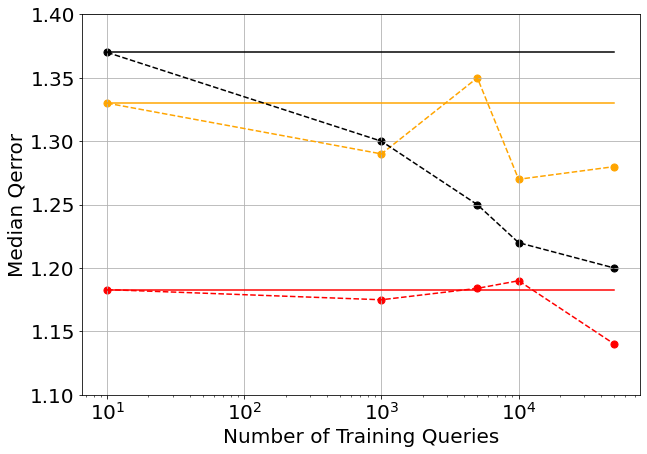

In [14]:
x = [10, 1000, 5000, 10000, 50000]
true_true = [1.183, 1.183, 1.183, 1.183, 1.183]
true_true_ft = [1.183, 1.175, 1.184, 1.190, 1.14]
true_est = [1.33, 1.33, 1.33, 1.33, 1.33]
true_est_ft = [1.33, 1.29, 1.35, 1.27, 1.28]
est_est = [1.37, 1.37, 1.37, 1.37, 1.37]
est_est_ft = [1.37, 1.30, 1.25, 1.22, 1.20]



plt.figure(figsize=(10,7))
plt.plot(x, true_true, color="red")
plt.plot(x, true_true_ft, color="red", linestyle='dashed')
plt.scatter(x, true_true_ft, color="red", s=50)

plt.plot(x, true_est, color="orange")
plt.plot(x, true_est_ft, color="orange", linestyle='dashed')
plt.scatter(x, true_est_ft, color="orange", s=50)


plt.plot(x, est_est, color="black")
plt.plot(x, est_est_ft, color="black", linestyle='dashed')
plt.scatter(x, est_est_ft, color="black", s=50)

plt.ylim(1.10, 1.4)
plt.ylabel("Median Qerror", fontsize=20)
plt.yticks(fontsize=20)
plt.xscale("log")
plt.xlabel("Number of Training Queries", fontsize=20)
plt.xticks(fontsize=20)
plt.grid()
plt.savefig("jobfull.pdf")

In [ ]:
x = [10, 1000, 5000, 10000, 50000]
true_true = [1.183, 1.183, 1.183, 1.183, 1.183]
true_true_ft = [1.183, 1.195, 1.184, 1.190, 1.14]
true_est = [1.33, 1.33, 1.33, 1.33, 1.33]
true_est_ft = [1.33, 1.29, 1.35, 1.27, 1.28]
est_est = [1.37, 1.37, 1.37, 1.37, 1.37]
est_est_ft = [1.37, 1.30, 1.25, 1.22, 1.20]



plt.figure(figsize=(10,7))
plt.plot(x, true_true, color="red")
plt.plot(x, true_true_ft, color="red", linestyle='dashed')
plt.scatter(x, true_true_ft, color="red", s=50)


plt.plot(x, est_est, color="black")
plt.plot(x, est_est_ft, color="black", linestyle='dashed')
plt.scatter(x, est_est_ft, color="black", s=50)

plt.ylim(1.10, 1.4)
plt.ylabel("Median Qerror", fontsize=20)
plt.yticks(fontsize=20)
plt.xscale("log")
plt.xlabel("Number of Training Queries", fontsize=20)
plt.xticks(fontsize=20)
plt.grid()
plt.savefig("jobfull.pdf")